c:\Users\Aneeqa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
c:\Users\Aneeqa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
h=256,l=3,o=90,a=49: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it, acc=0.614, loss=0.651]


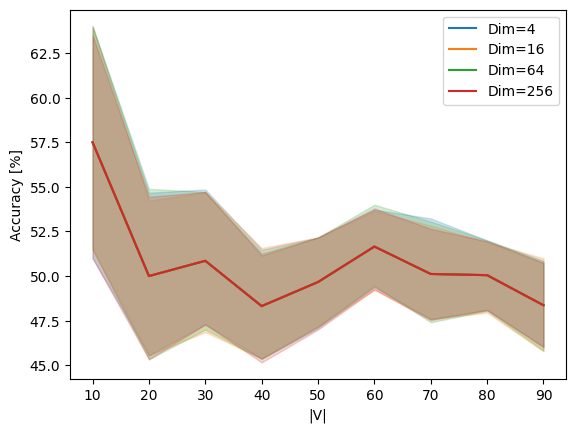

In [1]:
import numpy as np
import torch
from torch_geometric.data import Data


def tnm_tree(deg_1, deg_2):
    # build edges from depth 1 to root
    src_depth_1 = torch.arange(1, 3)
    tgt_depth_1 = torch.zeros((2,), dtype=torch.long)
    edges_depth_1 = torch.stack([src_depth_1, tgt_depth_1], dim=0)

    # sample edges from depth 2 to depth 1
    num_depth_2 = deg_1 + deg_2
    order = num_depth_2 + 3
    src_depth_2 = torch.arange(3, order)
    tgt_depth_2 = torch.ones((num_depth_2,), dtype=torch.long)
    tgt_depth_2[deg_1:] = 2

    edges_depth_2 = torch.stack([src_depth_2, tgt_depth_2], dim=0)

    edge_index = torch.cat([edges_depth_1, edges_depth_2], dim=1)

    x = torch.ones((order,), dtype=torch.float32)
    data = Data(x=x, edge_index=edge_index)
    return data


def get_tnm_trees(order):
    data_list = []
    max_idx = int(np.floor(order / 2))
    for i in range(max_idx+1):
        deg_1 = i
        deg_2 = order - i
        data = tnm_tree(deg_1, deg_2)
        data_list.append(data)
    return data_list




import torch
from torch.nn import Module, Linear, Sequential, BCEWithLogitsLoss, ModuleList, BatchNorm1d, ReLU, LeakyReLU, Dropout
from torch_geometric.nn import GraphConv, MessagePassing
from torch_geometric.nn.pool import global_add_pool, global_mean_pool
from tqdm import trange


class GraphConvLayer(Module):

    def __init__(self, in_dim, out_dim, dropout_p=0.0):
        super(GraphConvLayer, self).__init__()
        self.conv = GraphConv(in_channels=in_dim, out_channels=out_dim)
        self.act = ReLU(inplace=True)
        self.dropout = Dropout(dropout_p)

    def forward(self, x, edge_index):
        out = self.conv(x, edge_index)
        out = self.act(out)
        out = self.dropout(out)
        return out


class GNNLayer(MessagePassing):

    def __init__(self, in_dim, out_dim, dropout_p=0.0):
        super(GNNLayer, self).__init__(aggr='add')

        self.msg = Sequential(
            Linear(in_dim, out_dim),
            BatchNorm1d(out_dim, track_running_stats=False),
            ReLU(inplace=True),
            Linear(out_dim, out_dim),
            Dropout(dropout_p)
        )

        self.root_linear = Linear(in_dim, out_dim)

        self.up = Sequential(
            BatchNorm1d(out_dim, track_running_stats=False),
            ReLU(inplace=True),
            Dropout(dropout_p),
        )

    def forward(self, x, edge_index):
        msg = self.msg(x)
        rec = self.propagate(edge_index, x=msg)

        y = rec + self.root_linear(x)
        y = self.up(y)
        return y


class GNN(Module):

    def __init__(self, in_dim, out_dim, hidden_dim, num_layers, pool_fn='add', **kwargs):
        super(GNN, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        in_dims = [in_dim] + [hidden_dim] * (num_layers - 1)
        out_dims = [hidden_dim] * num_layers

        layers = []
        for in_dim, out_dim in zip(in_dims, out_dims):
            layers.append(GNNLayer(in_dim=in_dim, out_dim=out_dim))
        self.layers = ModuleList(layers)

        self.pool_fn = global_mean_pool if pool_fn == 'mean' else global_add_pool

        self.graph_cls = Sequential(
            Linear(hidden_dim, hidden_dim),
            BatchNorm1d(hidden_dim, track_running_stats=False),
            ReLU(inplace=True),
            Linear(hidden_dim, self.out_dim),
        )

        self.criterion = BCEWithLogitsLoss()

    def forward(self, data):
        x = data.x.view(-1, self.in_dim)
        for layer in self.layers:
            x = layer(x, data.edge_index)

        x = self.pool_fn(x, data.batch)
        y = self.graph_cls(x)
        return torch.sigmoid(y)  # return y

    def epoch(self, data, opt, steps, tqdm_prefix='', **kwargs):
        self.train()

        best_acc = 0.0
        with trange(steps) as t:
            t.set_description(tqdm_prefix)
            for s in t:
                opt.zero_grad()

                y_pred = self(data)
                y_true = data.y.view(-1, self.out_dim)
                loss = self.criterion(y_pred, y_true.float())

                loss.backward()
                opt.step()

                rounded = (y_pred > 0.0).long()
                correct = rounded == y_true

                acc = correct.float().mean().item()
                all_correct = correct.min().item()
                loss = loss.item()
                t.set_postfix(loss=loss, acc=acc)
                if acc > best_acc:
                    best_acc = acc

                if all_correct:
                    best_acc = 1.0
                    break

        return best_acc

    def evaluate(self, data):
        self.eval()
        with torch.no_grad():
            y_pred = self(data)
            y_true = data.y.view(-1, self.out_dim)

            rounded = (y_pred > 0.0).float()
            acc = (rounded == y_true).float().mean().cpu().item()
        return acc

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return opt

    def fit(self, data, train_steps, lr_start=1e-3, weight_decay=1e-5, device='cuda:0', **kwargs):
        opt = torch.optim.AdamW(self.parameters(), lr=lr_start, weight_decay=weight_decay)
        self.to(device)
        data.to(device)
        acc = self.epoch(data, opt, train_steps, **kwargs)
        return acc



from argparse import ArgumentParser
import numpy as np
import pandas as pd
import os

import torch
from torch_geometric.data import Batch




if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument("--num_layers", type=int, default=[3], nargs='+', help="Number of layers")
    parser.add_argument("--hidden_dim", type=int, default=[4, 16, 64, 256], nargs='+', help="Hidden Dimension")
    parser.add_argument("--lr", type=float, default=1.e-4, help="Learning Rate")
    parser.add_argument("--weight_decay", type=float, default=0, help="Weight Decay")
    parser.add_argument("--pool_fn", type=str, default='sum', help="Pool")
    parser.add_argument("--order", type=int, default=[10, 20, 30, 40, 50, 60, 70, 80, 90], nargs='+', help="Order of trees")
    parser.add_argument("--num_assign", type=int, default=50, help="Number of assignments to try per set of trees")
    parser.add_argument("--train_steps", type=int, default=10, help="Number of steps per epoch")
    parser.add_argument("--file_name", type=str, default='simple_tree_results.csv', help="CSV file to store results")
    parser.add_argument("--seed", type=int, default=6, help="the random seed for torch and numpy")
    args = parser.parse_args()
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    kwargs = vars(args)

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    csv_path = os.path.join('./results', f'{args.file_name}')
    os.makedirs('./results', exist_ok=True)
    results = []

    for o in args.order:
        data_list = get_tnm_trees(o - 3)
        data = Batch.from_data_list(data_list)
        for a in range(args.num_assign):
            data.y = torch.randint(0, 2, (len(data_list),), device=data.x.device)

            for h in args.hidden_dim:
                for l in args.num_layers:
                    model = GNN(in_dim=1, out_dim=1, hidden_dim=h, num_layers=l, pool_fn=args.pool_fn)

                    acc = model.fit(
                        data=data,
                        device=device,
                        tqdm_prefix=f'h={h},l={l},o={o},a={a}',
                        **kwargs
                    )

                    result_record = {
                        'order': o,
                        'assignment': a,
                        'hidden_dim': h,
                        'layers': l,
                        'accuracy': acc
                    }
                    results.append(result_record)
                    df = pd.DataFrame(results)
                    df.to_csv(csv_path)



from argparse import ArgumentParser
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument("--num_layers", type=int, default=[3], nargs='+', help="Number of layers")
    parser.add_argument("--hidden_dim", type=int, default=[4, 16, 64, 256], nargs='+', help="Hidden Dimension")
    parser.add_argument("--file_names", type=str, nargs='+', default=['simple_trees_results.csv'], help="CSV file to store results")
    parser.add_argument("--img_dir", type=str, default='results', help="Directory for saving plots")
    args = parser.parse_args()

    csv_paths = [os.path.join('./results', f'{n}') for n in args.file_names]
    df = pd.concat([pd.read_csv(p) for p in csv_paths])
    df['accuracy'] *= 100

    colors = sns.color_palette()
    plt.clf()

    for style_id, h in enumerate(args.hidden_dim):
        h_mask = df['hidden_dim'] == h
        for l in args.num_layers:
            l_mask = df['layers'] == l
            o_mask = df['order'] <= 90
            data = df[h_mask & l_mask & o_mask]

            ax = sns.lineplot(
                x='order',
                y='accuracy',
                data=data,
                alpha=1.0,
                color=colors[style_id],
                label=f'Dim={h}'
            )

            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
            ax.set(xlabel='|V|', ylabel='Accuracy [%]')

    plt.legend()
    plt.savefig(os.path.join(args.img_dir, f'plot_simple_trees.png'))
    plt.show()
